In [61]:
################################# SAFETY DATA (MEGAN'S LAW) - WEB SCRAPING FROM  PITTSBURGH SEX OFFENDER REGISTRY - ROCHA ##############################

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import Select
from webdriver_manager.chrome import ChromeDriverManager
import time

# Initialize Selenium WebDriver (Chrome)
chrome_options = Options()
chrome_options.add_argument("--headless")  # Runs Chrome in headless mode (no UI)
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

# Go to the webpage with Selenium
url = "https://www.meganslaw.psp.pa.gov/Search/MileRadiusSearch"
driver.get(url)

wait = WebDriverWait(driver, 10) 

# Automate filling in the search form
try:
    # Find and click the "Accept" button (targeting the form and the button class)
    accept_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//button[text()="Accept"]')))
    accept_button.click()

    print("Clicked the Accept button. Now proceeding to the search page...")
    address_field = WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.ID, 'enteredAddr1')))
    driver.execute_script("arguments[0].scrollIntoView(true);", address_field) 
    driver.execute_script("arguments[0].value = 'Hamburgh Hall';", address_field)

    # Select the city
    city_field = wait.until(EC.visibility_of_element_located((By.ID, 'selectedCity')))
    city_field.send_keys("PITTSBURGH")

    # Input ZIP code
    zip_field = wait.until(EC.visibility_of_element_located((By.ID, 'enteredZip')))
    zip_field.send_keys("15213")

    # Select radius (in miles)
    mile_radius_dropdown = Select(driver.find_element(By.ID, 'MileRadiusDDL'))
    mile_radius_dropdown.select_by_visible_text("3 Miles")

    # Submit the search form (adjust the submit button identifier as needed)
    submit_button = WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.NAME, 'MileRadiusSearchResults')))
    driver.execute_script("arguments[0].scrollIntoView(true);", submit_button)
    driver.execute_script("arguments[0].click();", submit_button)

    # Wait for the results page to load
    time.sleep(5)

    # Now proceed to scrape the result page
    offenders = driver.find_elements(By.CLASS_NAME, 'row.searchResultRow')

    # Initialize a list to store the extracted data
    offender_data = []

    while True:
        time.sleep(5)

        # Scrape the result page
        offenders = driver.find_elements(By.CLASS_NAME, 'row.searchResultRow')

        # Loop through each offender and extract details
        for offender in offenders:
            try:
                name = offender.find_element(By.CLASS_NAME, 'searchResultName').text
                tier = offender.find_elements(By.CLASS_NAME, 'gridDataItem.br-responsive-sm')[0].text
                birth_year = offender.find_elements(By.CLASS_NAME, 'gridDataItem.br-responsive-sm')[1].text
                address_block = offender.find_element(By.CLASS_NAME, 'searchResultAddress').text.split("\n")

                # New logic to handle the last line containing the ZIP code
                if address_block:
                    address = address_block[0].strip()  # Street Address (first line)
                    
                    # Extract the last line (City/State/ZIP)
                    last_line = address_block[-1].strip()

                    # Check if the last line contains "PA" (to handle out-of-state or transient addresses)
                    if "PA" in last_line:
                        # Get the ZIP code by splitting based on "PA" and then taking the last 5 characters
                        city_state_zip = last_line
                        zip_code = last_line.split("PA")[-1].strip()[:5]
                    else:
                        # Handle cases where ZIP might be missing (transients, out-of-state)
                        city_state_zip = last_line
                        zip_code = "N/A"  # Mark as N/A if ZIP is missing

                    # Append the extracted data
                    offender_data.append({
                        'Name': name,
                        'Tier': tier,
                        'Birth Year': birth_year,
                        'Address': address,
                        'City/State/ZIP': city_state_zip,
                        'ZIP Code': zip_code
                    })
                else:
                    print(f"Warning: Incomplete address for offender {name}")

            except Exception as e:
                print(f"Error scraping data for an offender: {e}")
                continue

        try:
            # Handle pagination
            next_button_li = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CLASS_NAME, 'PagedList-skipToNext'))
            )

            # Check if the "Next" button is disabled by looking at its class or missing href
            if "disabled" in next_button_li.get_attribute("class"):
                print("No more pages, 'Next' button is disabled.")
                break  # No more pages, stop the loop

            # Find the anchor tag inside the next button and click it
            next_link = next_button_li.find_element(By.TAG_NAME, 'a')
            next_href = next_link.get_attribute('href')  # Get the URL for the next page

            print(f"Navigating to next page: {next_href}")
            driver.execute_script("arguments[0].click();", next_link)  # Trigger the click via JavaScript

        except Exception as e:
            print(f"No more pages or error encountered: {e}")
            break  # No more next button, stop the loop

    # Close the browser when done
    driver.quit()

    # Print the extracted data
    if offender_data:
        for data in offender_data:
            print(data)
    else:
        print("No data found.")
    
except Exception as e:
    print(f"Error during scraping: {e}")
    driver.quit()

################################ SAFETY DATA (MEGAN'S LAW) - WEB SCRAPING FROM  PITTSBURGH SEX OFFENDER REGISTRY - ROCHA ##############################

Clicked the Accept button. Now proceeding to the search page...
Navigating to next page: https://www.meganslaw.psp.pa.gov/Search/MileRadiusSearchResultsAsync?page=2&enteredAddr1=Hamburgh%20Hall&selectedCity=PITTSBURGH&enteredZip=15213&selectedMileRadius=3&selectedSortBy=1&chkMileRadiusIncarcerated=False
Navigating to next page: https://www.meganslaw.psp.pa.gov/Search/MileRadiusSearchResultsAsync?page=3&enteredAddr1=Hamburgh%20Hall&selectedCity=PITTSBURGH&enteredZip=15213&selectedMileRadius=3&selectedSortBy=1&chkMileRadiusIncarcerated=False
Navigating to next page: https://www.meganslaw.psp.pa.gov/Search/MileRadiusSearchResultsAsync?page=4&enteredAddr1=Hamburgh%20Hall&selectedCity=PITTSBURGH&enteredZip=15213&selectedMileRadius=3&selectedSortBy=1&chkMileRadiusIncarcerated=False
Navigating to next page: https://www.meganslaw.psp.pa.gov/Search/MileRadiusSearchResultsAsync?page=5&enteredAddr1=Hamburgh%20Hall&selectedCity=PITTSBURGH&enteredZip=15213&selectedMileRadius=3&selectedSortBy=1&chkM

In [63]:
##################################### SAFETY DATA (MEGAN'S LAW) - CLEANED DATA AND EXPORTING TO CSV - ROCHA #######################################

import pandas as pd

# Function to clean the data
def clean_data(data):
    cleaned_data = []

    # Iterate over each offender's data (a dictionary)
    for offender in data:
        cleaned_offender = {}

        # Clean the 'Name' field
        cleaned_offender['Name'] = offender.get('Name', '').strip().title()

        # Clean the 'Tier' field (ensure it is consistent in case of typos or other formatting issues)
        cleaned_offender['Tier'] = offender.get('Tier', '').strip().capitalize()

        # Clean the 'Birth Year' (ensure it is numeric and not malformed)
        birth_year = offender.get('Birth Year', '').strip()
        if birth_year.isdigit():
            cleaned_offender['Birth Year'] = int(birth_year)  # Convert to integer
        else:
            cleaned_offender['Birth Year'] = None  # Set to None if invalid

        # Clean the 'Address' field (remove any extra spaces or unwanted characters)
        cleaned_offender['Address'] = offender.get('Address', '').strip().title()

        # Clean the 'City/State/ZIP' field (address cleanup)
        city_state_zip = offender.get('City/State/ZIP', '').strip()

        # Check if the format has comma separation, else handle other formats
        if ',' in city_state_zip:
            city_state_zip_parts = city_state_zip.split(',')
            cleaned_offender['City'] = city_state_zip_parts[0].strip().title()

            # Sometimes state and ZIP are combined in various formats (like "PA 15213")
            state_zip = city_state_zip_parts[1].strip().split(' ')
            if len(state_zip) == 2:
                cleaned_offender['State'] = state_zip[0].strip().upper()
                cleaned_offender['ZIP'] = state_zip[1].strip()
            else:
                cleaned_offender['State'] = state_zip[0].strip().upper() if state_zip else None
                cleaned_offender['ZIP'] = None
        else:
            # If no comma, we assume this field is not well-formed. Assign it as is.
            cleaned_offender['City/State/ZIP'] = city_state_zip

        # Append the cleaned offender's data to the list
        cleaned_data.append(cleaned_offender)

    return cleaned_data

# Use the real scraped offender data from your Selenium script
cleaned_offender_data = clean_data(offender_data)

# Convert to a pandas DataFrame for easier CSV export
df = pd.DataFrame(cleaned_offender_data)

# Export the cleaned data to a CSV file
df.to_csv('cleaned_offender_data.csv', index=False)

print("Data cleaned and exported to cleaned_offender_data.csv")

##################################### SAFETY DATA (MEGAN'S LAW) - CLEANED DATA AND EXPORTING TO CSV - ROCHA #######################################

Data cleaned and exported to cleaned_offender_data.csv



Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  1
Enter your ZIP code:  15201



There are 21 offenders in ZIP code 15201.


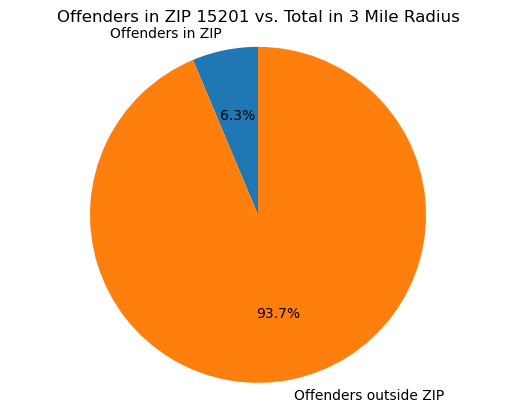


Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  2
Enter your ZIP code:  15207



Offenders in ZIP code 15207:
Arasin, Robert Alex
Chartrand, Michael
Cowden, Thomas Carl
Doctor, David Gary
Grayson, Phillip
Hunter, Raymond
Jette, Dion
Newkirk, Curtis
Phillips, Michael
Powell, Baron Lee
Quinn, John
Schwaibold, Todd William
Skweres, Adam Max
Thorton, Jesse William
Tuosto, Amy Elizabeth
Urban, Anthony
Xavier, Favian

Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  3
Enter your ZIP code:  15219



Addresses of offenders in ZIP code 15219:
Transient-Homeless
Renewal Ccc 2
1830 Wylie Ave
711 Cherokee St
612 Wylie Avenue
Renewal Ccc 2
Renewal Ccc 2
Absconded
Renewal Ccc 2
835 Herron Ave
Transient-Homeless
Transient-Homeless
Renewal Ccc 2
Absconded
2608 Bedford Avenue
713 Cherokee St
411 7Th Avenue
519 Herron Ave
2851 Bedford Ave
Transient-Homeless
Renewal Ccc 2
Renewal Ccc 2
Renewal Ccc 2
2042 Centre Ave
Renewal Ccc 2
748 Bryn Mawr Road
Renewal Ccc 2
2822 Webster Avenue
Transient-Homeless
536 Francis Street Apt 1
2033 Centre Ave
3029 Brereton Street
Renewal Ccc 2
Transient-Homeless
Transient-Homeless
Renewal Ccc 2
1000 Technology Drive
2133 Rose Street
1425 Forbes Ave
2239 Midtown Square
100 Ross St
Renewal Ccc 2
704 Second Ave
Renewal Ccc 2
100 Ross Street
Transient-Homeless
Renewal Ccc 2
208 Dinwiddie Street
2121 Center Avenue
Renewal Ccc 2


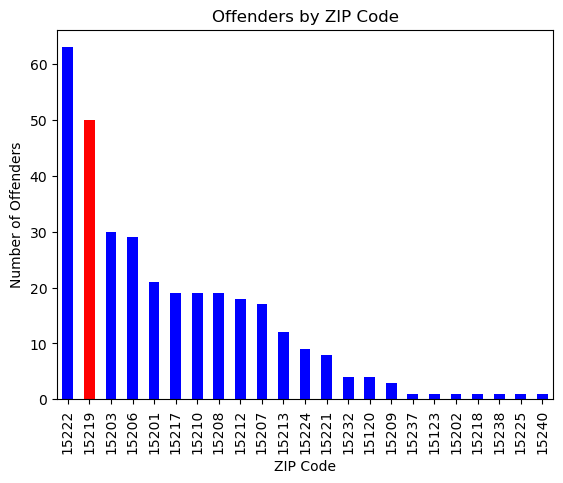


Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  4
Enter your ZIP code:  15240



Tier Explanation:
Tier 1: Lowest level of risk. Example crimes: Public indecency, Sexual harassment.
Tier 2: Moderate level of risk. Example crimes: Sexual assault, Indecent exposure.
Lifetime: High level of risk. Example crimes: Rape, Child molestation.

Tiers of offenders in ZIP code 15240:
Tier
Tier 1    1
Name: count, dtype: int64


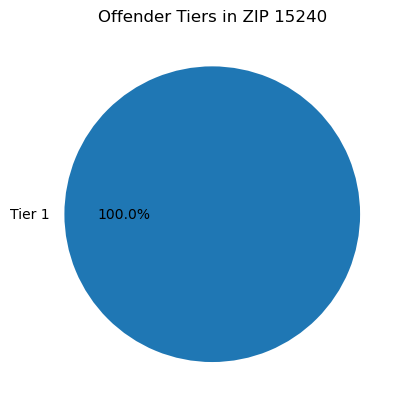


Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  4
Enter your ZIP code:  15209



Tier Explanation:
Tier 1: Lowest level of risk. Example crimes: Public indecency, Sexual harassment.
Tier 2: Moderate level of risk. Example crimes: Sexual assault, Indecent exposure.
Lifetime: High level of risk. Example crimes: Rape, Child molestation.

Tiers of offenders in ZIP code 15209:
Tier
Tier 2           1
Pre-sorna svp    1
Ten-year         1
Name: count, dtype: int64


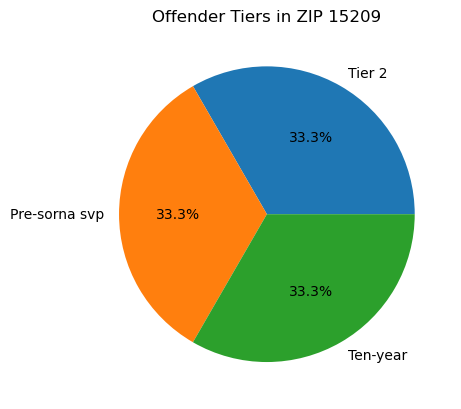


Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  2
Enter your ZIP code:  15120



Offenders in ZIP code 15120:
Ivory, Thomas Sean
Kelly, Charles Orlando
Marmino, Bobby Neal
Urrutia-Uribio, Christofer Mauricio

Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  0


Returning to Main Menu...


Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  4
Enter your ZIP code:  15202



Tier Explanation:
Tier 1: Lowest level of risk. Example crimes: Public indecency, Sexual harassment.
Tier 2: Moderate level of risk. Example crimes: Sexual assault, Indecent exposure.
Lifetime: High level of risk. Example crimes: Rape, Child molestation.

Tiers of offenders in ZIP code 15202:
Tier
Tier 1    1
Name: count, dtype: int64


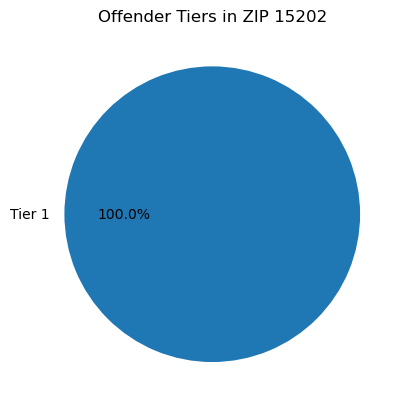


Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  15213


Invalid option, please try again.

Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  4
Enter your ZIP code:  15213



Tier Explanation:
Tier 1: Lowest level of risk. Example crimes: Public indecency, Sexual harassment.
Tier 2: Moderate level of risk. Example crimes: Sexual assault, Indecent exposure.
Lifetime: High level of risk. Example crimes: Rape, Child molestation.

Tiers of offenders in ZIP code 15213:
Tier
Tier 1      6
Lifetime    2
Tier 2      2
Tier 3      2
Name: count, dtype: int64


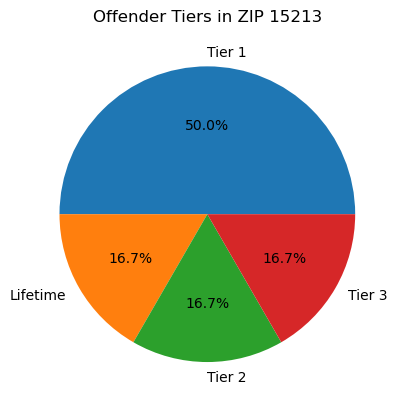


Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  3
Enter your ZIP code:  15213



Addresses of offenders in ZIP code 15213:
413 South Craig Street
3217 Juliet St
24 Oakland Square Apt #1
4801 Baum Blvd
4625 5Th Ave
403 Mckee Place
3616 5Th Avenue
263 Lawn St
4740 Baum Blvd
3206 Niagra Street
111 Hyman Place
2520 Wadsworth Street Apt #3


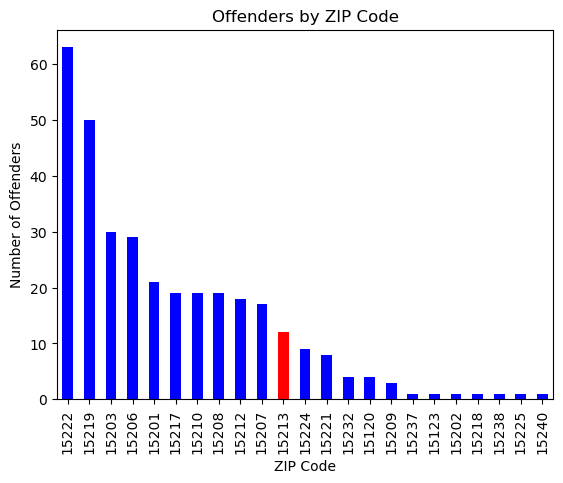


Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  1
Enter your ZIP code:  15218



There are 1 offenders in ZIP code 15218.


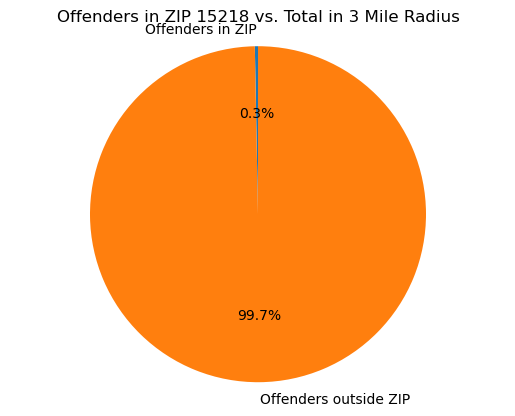


Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  4
Enter your ZIP code:  15240



Tier Explanation:
Tier 1: Lowest level of risk. Example crimes: Public indecency, Sexual harassment.
Tier 2: Moderate level of risk. Example crimes: Sexual assault, Indecent exposure.
Lifetime: High level of risk. Example crimes: Rape, Child molestation.

Tiers of offenders in ZIP code 15240:
Tier
Tier 1    1
Name: count, dtype: int64


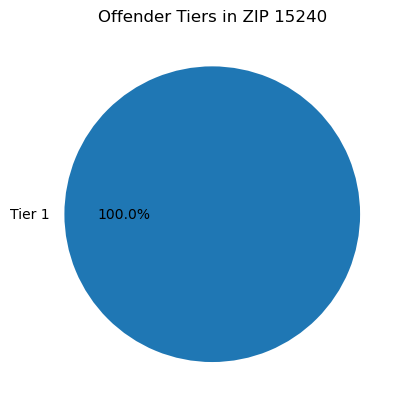


Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  1
Enter your ZIP code:  15222



There are 63 offenders in ZIP code 15222.


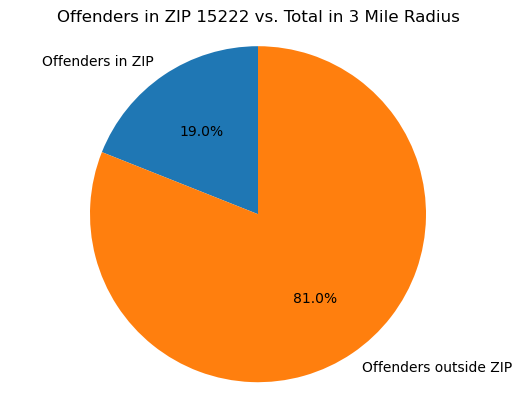


Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  2
Enter your ZIP code:  15222



Offenders in ZIP code 15222:
Batchelder, Stephen Gary
Busatto, Charles
Bush, Daniel
Carcia, Zachary Allen
Crossland, Richard Andrew
Davis, Malcolm J
Davis, Michael
Disiero, Daniel
Dorsey, Blaine Robert
Douglas, Danyial Lee
Ester, Jeremy Christopher
Fleming, Andrew James
Francis, Albert Leroy
Funches, Hugh
Gesin, Jarrod
Geyer, Jesse Ray
Gray, Jordan
Griffin, Brynn
Hale, Bilaal Abdulbadi
Harrison, Jeffery David
Jackson, Treron Arnez
Jankowski, Matthew M
Jensen, John
Johnson, Darren Emil
Jones, Dhaque
Kerlin Iii, Warren David
Kite, Matthew James
Kuhns, Travis James
Kujath, John Paul
Leitkam, Nicholas
Long, Daniel Peter
Lozovoy, Zackary Phillip
Lubiano, Anthony Ricardo
Lynch, Donaven Austin
Malinak, Christopher Thomas
Marino, Justin Matthew
Mays Jr, Kenneth
Mccann, William David
Merritt, Justin Tyler
Morant, Deonte Terrell
Morris Jr, Daniel Joseph
Morris, Jerrett Anthony
Mulholland, David Charles
Murray, Todd Michael
Nernberg, Mark Joseph
Owen Jr, Edwin Arthur
Painter, Andrew Nicholas
Pap


Enter your choice:  3
Enter your ZIP code:  15222



Addresses of offenders in ZIP code 15222:
Renewal Ccc
Renewal Ccc
301 3Rd Avenue
12M 8Th Street
Renewal Ccc
60 21St St
Transient-Homeless
Renewal Ccc
Renewal Ccc
Renewal Ccc
Renewal Ccc
239 4Th Ave Suite 1401
Renewal Ccc
Renewal Ccc
Renewal Ccc
301 Third Avenue
417 Smithfield St
1000 Liberty Ave
Renewal Ccc
Renewal Ccc
12Th 8Th St
930 Penn Ave
Renewal Ccc
2511 Penn Ave
Renewal Ccc
339 Boulevard Of The Allies
Renewal Ccc
Renewal Ccc
Renewal Ccc
703 Liberty Ave
2647 Smallman Street
12 8Th Street
Renewal Ccc
Renewal Ccc
Renewal Ccc
Renewal Ccc
239 4Th Ave.
808 Liberty Ave
210 Forbes Ave
320 6Th Ave
Renewal Ccc
1100 Liberty Ave
1000 Liberty Ave
301 3Rd Ave
2016 Smallman St.
Renewal Ccc
Renewal Ccc
2315 Liberty Ave
Renewal Ccc
2201 Liberty Avenue
301 3Rd Ave
1000 Fort Duquesne Blvd
Renewal Ccc
Renewal Ccc
Renewal Ccc
Renewal Ccc
Renewal Ccc
606 Liberty Ave
301 3Rd Ave Apt 1302
1001 Liberty Ave
1904 Penn Ave
Renewal Ccc
339 Boulevard Of The Allies


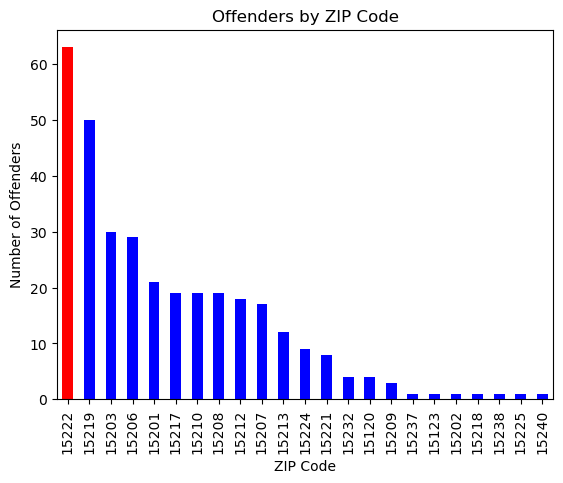


Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240



Enter your choice:  4
Enter your ZIP code:  15222



Tier Explanation:
Tier 1: Lowest level of risk. Example crimes: Public indecency, Sexual harassment.
Tier 2: Moderate level of risk. Example crimes: Sexual assault, Indecent exposure.
Lifetime: High level of risk. Example crimes: Rape, Child molestation.

Tiers of offenders in ZIP code 15222:
Tier
Tier 1                       15
Tier 3                       11
Tier 2                       11
Pre-sorna svp                 8
Out-of-state                  7
Lifetime                      6
Sexually violent predator     3
Ten-year                      2
Name: count, dtype: int64


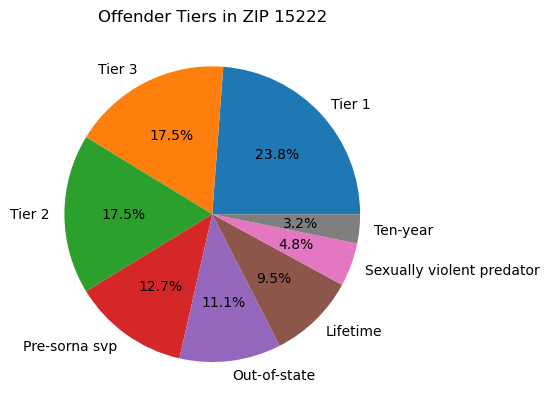


Please choose an option:
0. Return to Main Menu
1. How many offenders are in my area?
2. Who are the offenders?
3. Where are the offenders in my area?
4. How bad are the offenders in my area?
5. Quit

All data is within a 3-mile radius of Heinz College.
Zip Codes Covered: 15120, 15123, 15201, 15202, 15203, 15206, 15207, 15208, 15209, 15210, 15212, 15213, 15217, 15218, 15219, 15221, 15222, 15224, 15225, 15232, 15237, 15238, 15240


In [ ]:
##################################### SAFETY DATA (MEGAN'S LAW) - USER EXPERIENCE & VISUALIZATION - ROCHA #######################################

import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned CSV data
df = pd.read_csv('cleaned_offender_data.csv')

# Ensure ZIP codes are treated as strings and remove any rows with missing ZIP codes
df['ZIP'] = df['ZIP'].astype(str).str.strip()  # Convert to string and strip spaces
df = df[df['ZIP'].notna()]  # Remove any rows with missing ZIP

# Get unique ZIP codes from the data and sort them in ascending order
available_zip_codes = sorted(df['ZIP'].unique().tolist())

# Function to display the main menu
def main_menu():
    print("\nPlease choose an option:")
    print("0. Return to Main Menu")
    print("1. How many offenders are in my area?")
    print("2. Who are the offenders?")
    print("3. Where are the offenders in my area?")
    print("4. How bad are the offenders in my area?")
    print("5. Quit")
    print("\nAll data is within a 3-mile radius of Heinz College.")
    print("Zip Codes Covered:", ', '.join(available_zip_codes))  # Display all zip codes in one line
    return input("\nEnter your choice: ")

# Function to allow free ZIP code input but check if it's in the dataset
def input_zip_code():
    zip_code = input("Enter your ZIP code: ").strip()
    
    if zip_code in available_zip_codes:
        return zip_code
    else:
        print(f"Invalid ZIP code: {zip_code}. Please enter one of the following ZIP codes:")
        print(", ".join(available_zip_codes))
        return input_zip_code()

# Function to find the number of offenders in a zip code
def offenders_in_area(zip_code):
    total_offenders = len(df)
    offenders_in_zip = df[df['ZIP'] == zip_code]
    offenders_count = len(offenders_in_zip)
    
    print(f"\nThere are {offenders_count} offenders in ZIP code {zip_code}.")
    
    # Plot pie chart
    labels = ['Offenders in ZIP', 'Offenders outside ZIP']
    sizes = [offenders_count, total_offenders - offenders_count]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(f"Offenders in ZIP {zip_code} vs. Total in 3 Mile Radius")
    plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
    plt.show()

# Function to find the names of offenders in a zip code
def offenders_names(zip_code):
    offenders_in_zip = df[df['ZIP'] == zip_code]
    if not offenders_in_zip.empty:
        print(f"\nOffenders in ZIP code {zip_code}:")
        for name in offenders_in_zip['Name']:
            print(name)
    else:
        print(f"\nNo offenders found in ZIP code {zip_code}.")

# Function to find the addresses of offenders in a zip code and plot a graph
def offenders_addresses(zip_code):
    offenders_in_zip = df[df['ZIP'] == zip_code]
    
    if not offenders_in_zip.empty:
        print(f"\nAddresses of offenders in ZIP code {zip_code}:")
        for address in offenders_in_zip['Address']:
            print(address)
            
        # Plot bar chart for offenders by zip code
        zip_counts = df['ZIP'].value_counts()
        zip_counts.plot(kind='bar', color=['red' if x == zip_code else 'blue' for x in zip_counts.index])
        plt.title('Offenders by ZIP Code')
        plt.xlabel('ZIP Code')
        plt.ylabel('Number of Offenders')
        plt.show()
    else:
        print(f"\nNo offenders found in ZIP code {zip_code}.")

# Function to explain offender tiers and plot pie chart of tiers in zip code
def offenders_tiers(zip_code):
    offenders_in_zip = df[df['ZIP'] == zip_code]
    
    # Explanation of tiers and examples of crimes
    print("\nTier Explanation:")
    print("Tier 1: Lowest level of risk. Example crimes: Public indecency, Sexual harassment.")
    print("Tier 2: Moderate level of risk. Example crimes: Sexual assault, Indecent exposure.")
    print("Lifetime: High level of risk. Example crimes: Rape, Child molestation.")

    if not offenders_in_zip.empty:
        tier_counts = offenders_in_zip['Tier'].value_counts()
        print(f"\nTiers of offenders in ZIP code {zip_code}:")
        print(tier_counts)
        
        # Plot pie chart of tier distribution
        tier_counts.plot(kind='pie', autopct='%1.1f%%')
        plt.title(f"Offender Tiers in ZIP {zip_code}")
        plt.ylabel('')  # Remove y-axis label
        plt.show()
    else:
        print(f"\nNo offenders found in ZIP code {zip_code}.")

# Main function to handle user input and menu selection
def user_interface():
    while True:
        choice = main_menu()
        
        if choice == '0':
            print("Returning to Main Menu...\n")
            continue
        
        elif choice == '1':
            zip_code = input_zip_code()
            offenders_in_area(zip_code)
        
        elif choice == '2':
            zip_code = input_zip_code()
            offenders_names(zip_code)
        
        elif choice == '3':
            zip_code = input_zip_code()
            offenders_addresses(zip_code)
        
        elif choice == '4':
            zip_code = input_zip_code()
            offenders_tiers(zip_code)
        
        elif choice == '5':
            print("Thank you for using the system. Goodbye!")
            break
        
        else:
            print("Invalid option, please try again.")

# Run the user interface
user_interface()

##################################### SAFETY DATA (MEGAN'S LAW) - USER EXPERIENCE & VISUALIZATION - ROCHA #######################################